### Responsible Data Science: Auditing an Automated Decision System for Stroke Prediction
- Team: Yash Jha, Jon Dinh 
- Dataset: Deshpande, T. (Contributor.). (2021, January 26). Stroke Prediction Dataset. Kaggle. Retrieved March 21, 2023, from https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset 
- Goals: Achieve an ADS such that it is fair, performant, and reflects the underlying real world population. 

- The report includes looking at data distribution imbalances, data leakage from improper handling, feature selection methods, sampling methods, parameter tuning, fairness interventions and fairness metrics. 
 


\\Fairness-Full-Tree-1200x908.png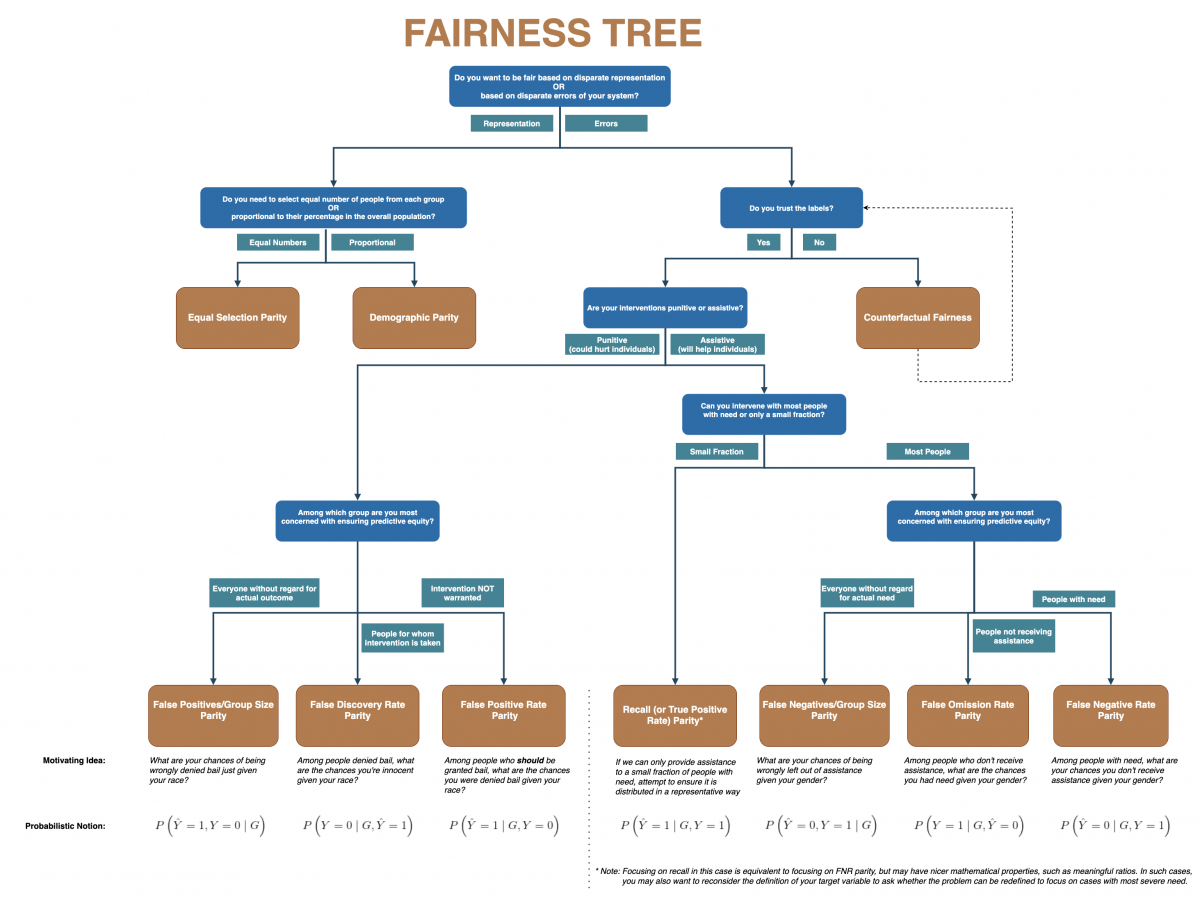

# Settings and Imports 

In [1]:
# paths
DATAPATH = 'healthcare-dataset-stroke-data.csv'

# import data management
import numpy as np
import pandas as pd

# import visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno

# import data processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif,chi2, f_classif
import shap

# import models
from xgboost import XGBClassifier

# import fairness interventions
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.postprocessing import ThresholdOptimizer

# import performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
import lime
import lime.lime_tabular

# import fairness metrics
# from aequitas.group import Group
# from aequitas.bias import Bias
# from aequitas.fairness import Fairness
# from aequitas.plotting import Plot
from fairlearn.reductions import DemographicParity, ErrorRate
from fairlearn.metrics import MetricFrame, equalized_odds_ratio
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate 
from fairlearn.metrics import false_negative_rate, false_positive_rate

# import basic functions
from IPython.display import display, clear_output, HTML
from IPython import display
import warnings
warnings.filterwarnings('ignore')

# balanced distributions
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline

# setting
pd.set_option('display.max_columns', None)

clear_output()

### Exploratory Data Analysis and Data Profiling 

In [2]:
data = pd.read_csv(DATAPATH)

# view the shape
print('Shape of original data: ', data.shape)
data.head()

Shape of original data:  (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# what are the column names and dtypes?
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
# stats of numerical data
numerical_cols = list(data.describe(exclude = 'object').drop(['id','stroke'], axis=1).columns)
data.describe(exclude = 'object')

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Numerical Features

There are 3 numerical feature columns that are not indicators. These features will be normalized and standardized. We'll look at the distribution for each. 

Text(0.5, 1.0, 'bmi distribution')

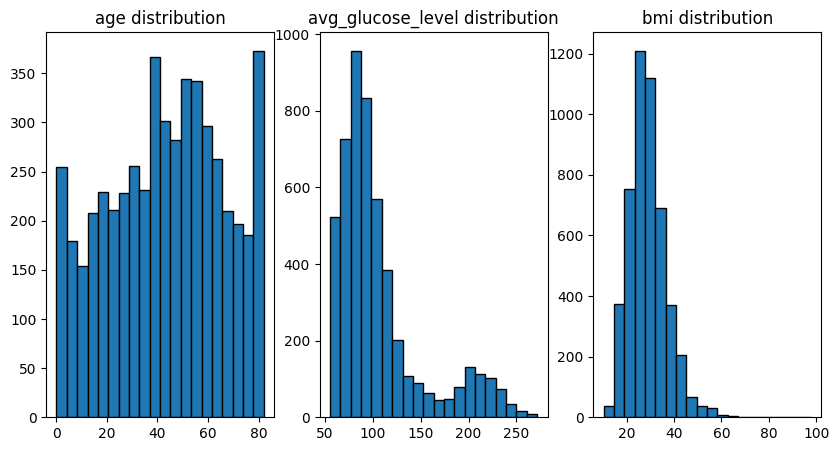

In [5]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
ax[0].hist(data['age'], bins = 20, ec = 'black');
ax[0].set_title('age distribution')
ax[1].hist(data['avg_glucose_level'], ec = 'black', bins = 20);
ax[1].set_title('avg_glucose_level distribution')
ax[2].hist(data['bmi'], ec = 'black', bins = 20);
ax[2].set_title('bmi distribution')

### Categorical Data 

In [6]:
# stats of categorical data
categorical_cols = list(data.describe(exclude = ['float64', 'int64']).columns)
data.describe(exclude = ['float64', 'int64'])

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


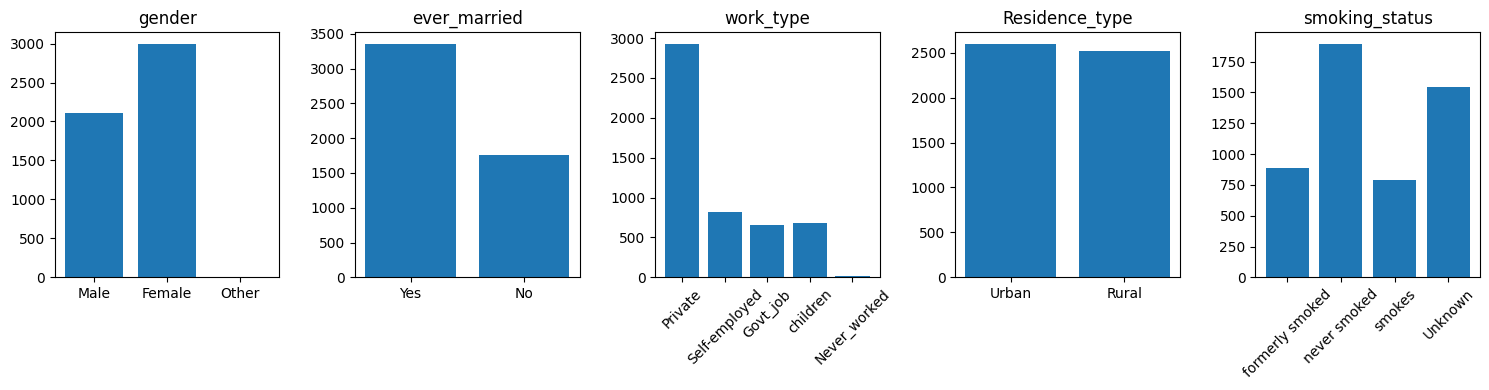

In [7]:
# distributions of categorical data
fig, ax = plt.subplots(1, 5, figsize = (15, 4))
ax[0].bar(data['gender'].unique(), data['gender'].value_counts(sort=False));
ax[0].set_title('gender')
ax[1].bar(data['ever_married'].unique(), data['ever_married'].value_counts(sort=False));
ax[1].set_title('ever_married')
ax[2].bar(data['work_type'].unique(), data['work_type'].value_counts(sort=False));
ax[2].set_title('work_type')
ax[2].set_xticklabels(data['work_type'].unique(), rotation = 45)
ax[3].bar(data['Residence_type'].unique(), data['Residence_type'].value_counts(sort=False));
ax[3].set_title('Residence_type')
ax[4].bar(data['smoking_status'].unique(), data['smoking_status'].value_counts(sort=False));
ax[4].set_title('smoking_status')
ax[4].set_xticklabels(data['smoking_status'].unique(), rotation = 45)
plt.tight_layout()
plt.show()

<Axes: >

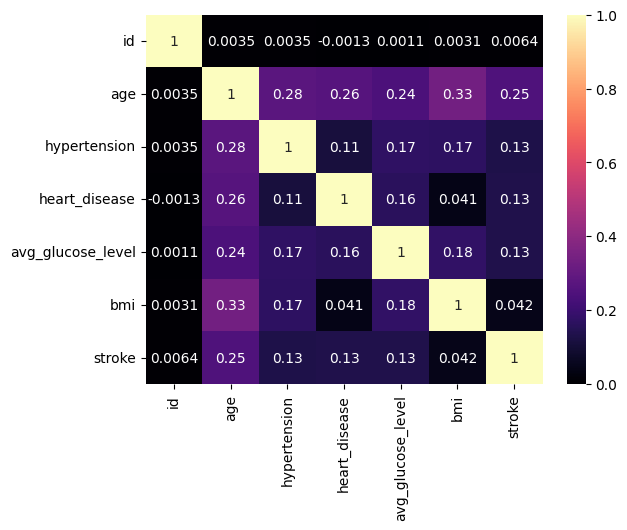

In [8]:
# what is the correlation between features in the data
sns.heatmap(data.drop(categorical_cols, axis = 1).corr(), cmap = 'magma', annot = True)

### Null Features

Below, we see that all current NULL values, reside in the BMI feature. 

Number of NULL entries:  201
Percentage of NULL entries: 0.328%


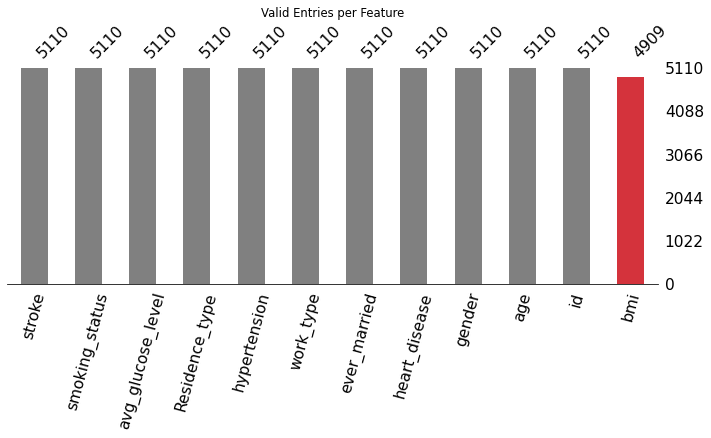

In [9]:
# look into the null values
print('Number of NULL entries: ', data.isnull().sum().sum())
print('Percentage of NULL entries: {}%'.format(round(data.isnull().sum().sum()/(data.shape[0]*data.shape[1])*100, 3)))

# we see that all the NULL values reside in the BMI feature
colors = list(['grey']*11) + ['#D4333C']
fig, ax = plt.subplots(figsize = (12, 4), dpi = 70)
msno.bar(data, sort = 'descending', ax=ax, labels = 'off', filter = 'top', color = colors)
ax.set_title('Valid Entries per Feature')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, ha = 'center', alpha = 1)
ax.set_yticklabels('')
ax.spines['bottom'].set_visible(True)
fig.show()

### Population Distribution: Stroke versus No-Stroke

The chart helps visualize the imbalance of the data. The wide imbalance must be addressed in order for the model to generalize within an industry space. 

Text(0.5, 1.0, 'Stroke Events (%)')

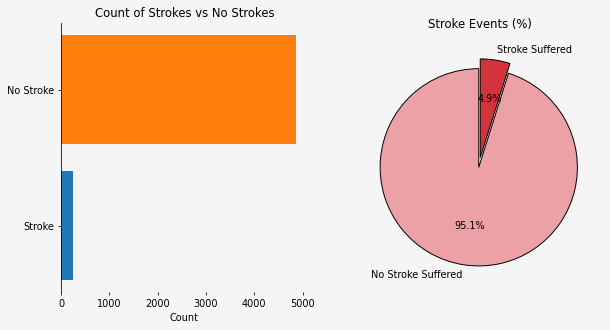

In [10]:
# horizontal bar plot of positive vs negative observations -> distribution
grouped = pd.DataFrame(data.groupby(['stroke'])['stroke'].count())
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5), dpi =70)
fig.patch.set_facecolor('#f6f5f5')
ax[0].set_facecolor('#f6f5f5')
ax[0].barh('Stroke', grouped.stroke[1])
ax[0].barh('No Stroke', grouped.stroke[0])
ax[0].set_title('Count of Strokes vs No Strokes')
ax[0].set_xlabel('Count')
ax[0].axes.get_yaxis().set_visible(True)
ax[0].axes.get_xaxis().set_visible(True)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

# circle chart
colors = ['#ECA1A6','#D4333C']
l = list(data['stroke'].value_counts())
circle = [l[0] / sum(l) * 100,l[1] / sum(l) * 100]
ax[1].pie(circle,
        labels = ['No Stroke Suffered','Stroke Suffered'],
        autopct='%1.1f%%',
        startangle = 90,
        explode = (0.1,0),
        colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
ax[1].set_title('Stroke Events (%)')

### Uni-variate Analysis of Numerical Features by Means

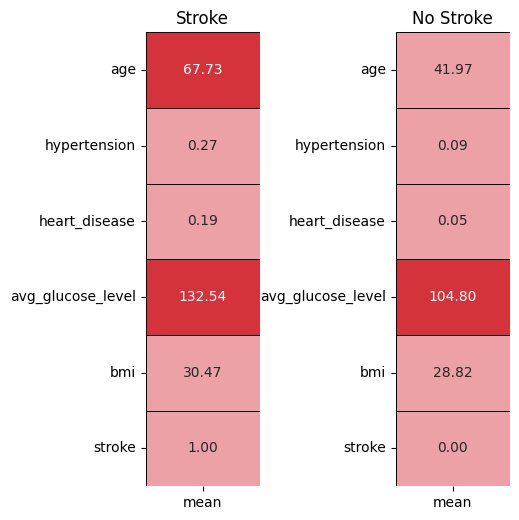

In [11]:
stroke = data[data['stroke'] == 1].drop(['id'], axis = 1).describe().T
no_stroke = data[data['stroke'] == 0].drop(['id'], axis = 1).describe().T

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(stroke[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Stroke');

plt.subplot(1,2,2)
sns.heatmap(no_stroke[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('No Stroke');

fig.tight_layout(pad = 0)

### Helper Functions for Model Evaluation and Metric Storage

In [12]:
def clean(DATAPATH):
      # data read in + vars
      data = pd.read_csv(DATAPATH)
      # data cleaning
      df = data.drop(['id'], axis = 1)
      df.bmi.fillna(data.bmi.mean(), inplace = True)
      df = df[df['gender'] != 'Other']
      return df

In [13]:
def encode(data, categorical_cols):
      df = data.copy(deep = True)
      encoder = LabelEncoder()
      # preprocessing
      for i in categorical_cols:
          df[i] = encoder.fit_transform(df[i])
          print(encoder.classes_)
      return df

In [14]:
def drop_feature(x_train, x_test): 
    # feature selection drop
    x_train = x_train.drop(['smoking_status', 'heart_disease', 'hypertension', 'bmi'], axis = 1)
    x_test = x_test.drop(['smoking_status', 'heart_disease', 'hypertension', 'bmi'], axis = 1)
    return x_train, x_test

In [15]:
def tts(df):
      X = df[[x for x in df.columns if x not in ['id', 'stroke']]]
      Y = df['stroke']
      # splitting
      x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 1, stratify = Y)
      return x_train, x_test, y_train, y_test

In [16]:
# NOTE: after this step, consider the data to be synthetic, therefore do not give high weight to accuracy
# NOTE: (continued) instead, focus on other evaluation metrics such as precision, recall, and F1-score

def under_smote(x_train, y_train):
    """
    Hybrid resampling method used in original ADS. 
    Undersamples the majority class by 0.1. 
    Generates synthetic minority classes to 1:1 ratio of previous undersampled majority class.
    """
    under = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    over = SMOTE()
    x_train, y_train = under.fit_resample(x_train, y_train) 
    x_train, y_train = over.fit_resample(x_train, y_train) 
    print(y_train.value_counts) # class distribution should now be relatively even in the training set
    return x_train, y_train

def adasyn(x_train, y_train):
    """
    Generalized SMOTE algorithm. Attempts to oversample the minorty class, considering 
    density distribution. Adaptively changes the decision boundaries. 
    """
    ada = ADASYN(sampling_strategy='auto', random_state=42)
    x_train, y_train = ada.fit_resample(x_train, y_train)
    print(Counter(y_train))
    return x_train, y_train

def smote_tomek(x_train, y_train):
    """
    Hybrid undersampling and oversampling: clean overlapping datapoints for each class. 
    """
    smtom = SMOTETomek(sampling_strategy='auto', random_state=42)
    x_train, y_train = smtom.fit_resample(x_train, y_train)
    print(Counter(y_train))
    return x_train, y_train

def smote_enn(x_train, y_train):
    smoenn = SMOTEENN(sampling_strategy='auto', random_state=42)
    x_train, y_train = smoenn.fit_resample(x_train, y_train)
    print(Counter(y_train))
    return x_train, y_train

In [17]:
def scaling(x_train, x_test):
    # ADS normalizes those without normal distribution
    # ADS standardizes those that have normal distribution, but large ranges

    # scalers
    mms = MinMaxScaler() 
    ss = StandardScaler() 

    # Normalization
    x_train['age'] = mms.fit_transform(x_train[['age']])
    x_test['age'] = mms.transform(x_test[['age']])
    x_train['avg_glucose_level'] = mms.fit_transform(x_train[['avg_glucose_level']])
    x_test['avg_glucose_level'] = mms.transform(x_test[['avg_glucose_level']])

    # Standardization
    x_train['ever_married'] = ss.fit_transform(x_train[['ever_married']]); x_test['ever_married'] = ss.transform(x_test[['ever_married']])
    x_train['work_type'] = ss.fit_transform(x_train[['work_type']]); x_test['work_type'] = ss.transform(x_test[['work_type']])
    x_train['Residence_type'] = ss.fit_transform(x_train[['Residence_type']]); x_test['Residence_type'] = ss.transform(x_test[['Residence_type']])
    return x_train, x_test

In [18]:
def preprocess_data(func= []):
    df = clean(DATAPATH)
    df = encode(df, categorical_cols)
    x_train, x_test, y_train, y_test = tts(df)
    for f in func:
        x_train, y_train = f(x_train, y_train)
    x_train, x_test = scaling(x_train, x_test)
    return x_train, x_test, y_train, y_test

In [19]:
def corr_remover(x_train, x_test, sensitive_feature):
    """
    Correlation remover: Do this after any feature extraction or feature selection
    """
    
    # grab column names
    column_names = list(x_train.columns.values)
    column_names.remove(sensitive_feature)

    # create correlation remover from FairLearn
    cr = CorrelationRemover(sensitive_feature_ids=[sensitive_feature], alpha=1.0)

    # Fit our correlation removing model on *only* training data
    cr.fit(x_train)

    # Remove correlations on training 
    x_train_cr = cr.transform(x_train) # returns a numpy array, not a dataframe
    x_train_cr = pd.DataFrame(x_train_cr, columns=column_names, index=x_train.index)
    x_train_cr[sensitive_feature] = x_train[sensitive_feature]

    # Remove correlations on test
    x_test_cr = cr.transform(x_test)
    x_test_cr = pd.DataFrame(x_test_cr, columns=column_names, index=x_test.index)
    x_test_cr[sensitive_feature] = x_test[sensitive_feature]
    return x_train, x_test

In [20]:

def eval(pipe, x_train, y_train, x_test, y_test, show_roc = True, show_cm = True, sensitive_feature = None):
    
    # fit and predict pipeline
    if sensitive_feature:
      pipe.fit(x_train, y_train, sensitive_features = x_train[sensitive_feature].replace({0:'female', 1:'male'}))
      prediction = pipe.predict(x_test, sensitive_features = x_test[sensitive_feature].replace({0:'female', 1:'male'}))
    else:
      pipe.fit(x_train, y_train)
      prediction = pipe.predict(x_test)

    # obtain performance metrics
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, prediction, average = 'weighted')
    cm = confusion_matrix(y_test,prediction)
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    roc_acc = roc_auc_score(y_test, prediction)

    # obtain fairness metrics
    sensitive_features_gender = x_test['gender'].replace({0:'female', 1:'male'})
    metrics = {'accuracy': accuracy_score, 'selection_rate': selection_rate, 'FNR': false_negative_rate, 'FPR': false_positive_rate}
    grouped_on_gender = MetricFrame(metrics = metrics, y_true = y_test, y_pred = prediction, sensitive_features = sensitive_features_gender)

    # plot roc_auc and cvs
    if show_roc:
        print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(pipe,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
        print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
        display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_acc, estimator_name = 'XGBoost')
        display.plot()
        plt.show()

    # plot the confusion matrix
    if show_cm:      
        names = ['True Neg','False Pos','False Neg','True Pos']
        counts = [value for value in cm.flatten()]
        colors = ['#ECA1A6','#D4333C']
        percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
        labels = np.asarray(labels).reshape(2,2)
        plt.subplots(figsize = (3,3));
        sns.heatmap(cm,annot = labels,cmap = colors,fmt ='')
        
    # create res object to return 
    results={'acc': accuracy_score(y_test, prediction), #(cm[1][1] + cm[0][0]) / (cm[0][0] + cm[0][1] + cm[1][0]+ cm[1][1]) ,
             'ppv':precision,                           #cm[1][1] / (cm[1][1]+cm[0][1]),
             'npv':cm[0][0] / (cm[0][0]+cm[1][0]),
             'recall':recall,                           #cm[1][1] / (cm[1][1] + cm[1][0]),
             'f1':fscore,
             'TN': cm[0][0],
             'FP': cm[0][1],
             'FN': cm[1][0],
             'TP': cm[1][1],
             'roc_acc':roc_acc,
             'FPR': cm[0][1] / (cm[0][1] + cm[0][0]),
             'TPR': cm[1][1] / (cm[1][1] + cm[1][0]),
             'TNR': cm[0][0] / (cm[0][0] + cm[0][1]),
             'FNR': cm[1][0] / (cm[1][0] + cm[1][1]),
             'FNRP':grouped_on_gender.ratio()[2],
             'equalized_odds_ratio':equalized_odds_ratio(y_test, prediction, sensitive_features = x_test['gender']),
             'demo_parity_diff': demographic_parity_difference(y_test, prediction, sensitive_features = x_test['gender']),
             'demo_parity_ratio': demographic_parity_ratio(y_test, prediction, sensitive_features = x_test['gender']),
             'female_acc': grouped_on_gender.by_group.iloc[0, 0],
             'female_sr': grouped_on_gender.by_group.iloc[0,1],
             'female_FNR': grouped_on_gender.by_group.iloc[0,2],
             'female_FPR': grouped_on_gender.by_group.iloc[0,3],
             'male_acc': grouped_on_gender.by_group.iloc[1, 0],
             'male_sr': grouped_on_gender.by_group.iloc[1,1],
             'male_FNR': grouped_on_gender.by_group.iloc[1,2],
             'male_FPR': grouped_on_gender.by_group.iloc[1,3]}
    
    return results, grouped_on_gender, prediction

In [21]:
def check_cm(y_test, prediction):
  TP = 0
  FP = 0
  TN = 0
  FN = 0
  for a, b in zip(y_test, prediction1):
    if a == 1 and b == 1:
      TP += 1
    elif a == 0 and b == 1:
      FP += 1
    elif a == 0 and b == 0:
      TN += 1
    else:
      FN += 1
  print('TP: ', TP)
  print('FP: ', FP)
  print('TN: ', TN)
  print('FN: ', FN)

In [22]:
def store_res(exp_result,exp_name,overall_result=pd.DataFrame()):
    for i in exp_result.keys():
        exp_result[i] = np.round(exp_result[i], 3)
    df=pd.DataFrame(exp_result,index=[exp_name])
    return pd.concat([overall_result,df],axis=0)

### Cleaning and Preprocessing

['Female' 'Male']
['No' 'Yes']
['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
['Rural' 'Urban']
['Unknown' 'formerly smoked' 'never smoked' 'smokes']
Counter({0: 2490, 1: 2490})


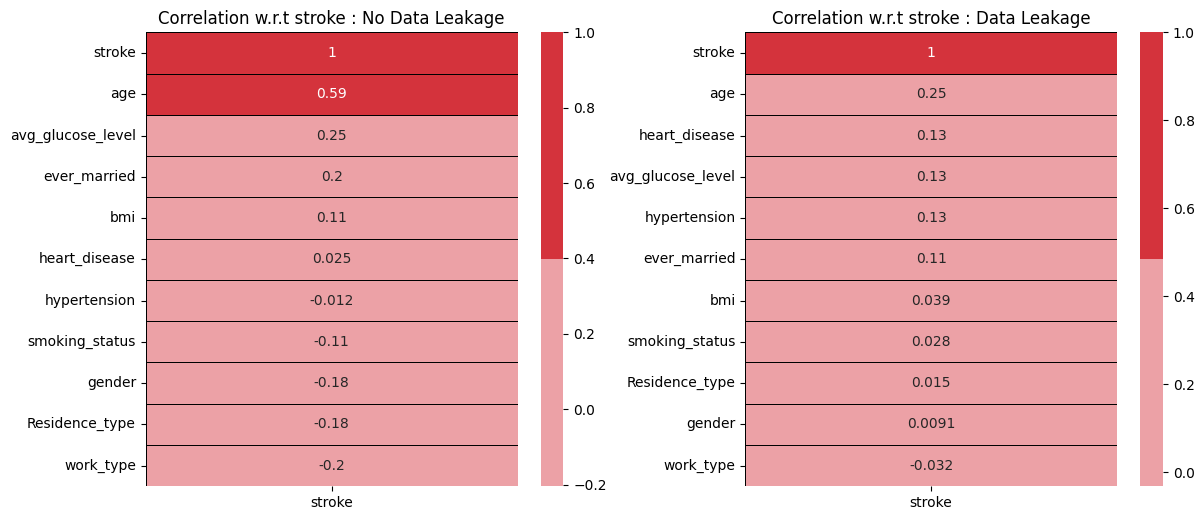

In [23]:
# cleaning
df = clean(DATAPATH)

# encode
df = encode(df, categorical_cols)

# Unbalanced distribution with bias for "no stroke" 
# NOTE: original system did resampling before splitting, allowing data leakage
under = RandomUnderSampler(sampling_strategy = 0.1, random_state = 1)
over = SMOTE(sampling_strategy = 1, random_state = 1)
X = df.iloc[:, :10] 
Y = df.iloc[:, 10] 
X, Y = under.fit_resample(X, Y) 
X, Y = over.fit_resample(X, Y) 
print(Counter(Y)) 

# splitting data into train and validation sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 1, stratify = Y)

# visualize the data leakage vs no data leakage
df_noleak = x_train.copy(deep = True)
df_noleak['stroke'] = y_train
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))
plt.subplot(1,2,1)
corr = df_noleak.corrwith(df_noleak['stroke']).sort_values(ascending = False).to_frame()
corr.columns = ['stroke']
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t stroke : No Data Leakage');

plt.subplot(1,2,2)
corr = df.corrwith(df['stroke']).sort_values(ascending = False).to_frame()
corr.columns = ['stroke']
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t stroke : Data Leakage');
fig.tight_layout(pad = 0)
plt.show()

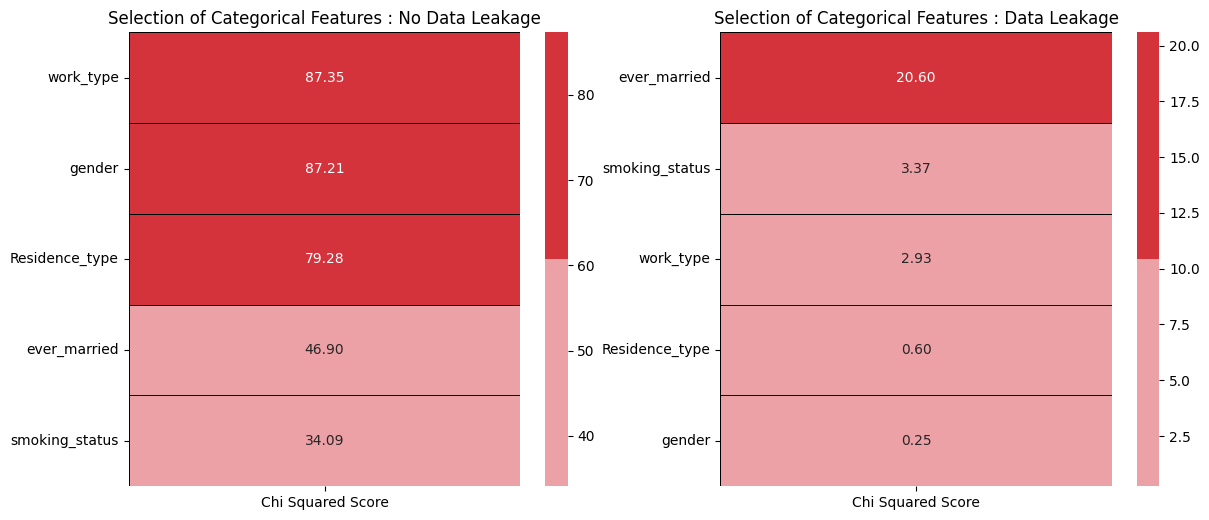

In [24]:
# feature selection for categorical features
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

plt.subplot(1,2,1)
features = x_train.loc[:,categorical_cols]
target = y_train

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features : No Data Leakage');

plt.subplot(1,2,2)
features = df.loc[:,categorical_cols]
target = df.loc[:,'stroke']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features : Data Leakage')
fig.tight_layout(pad = 0)
plt.show()

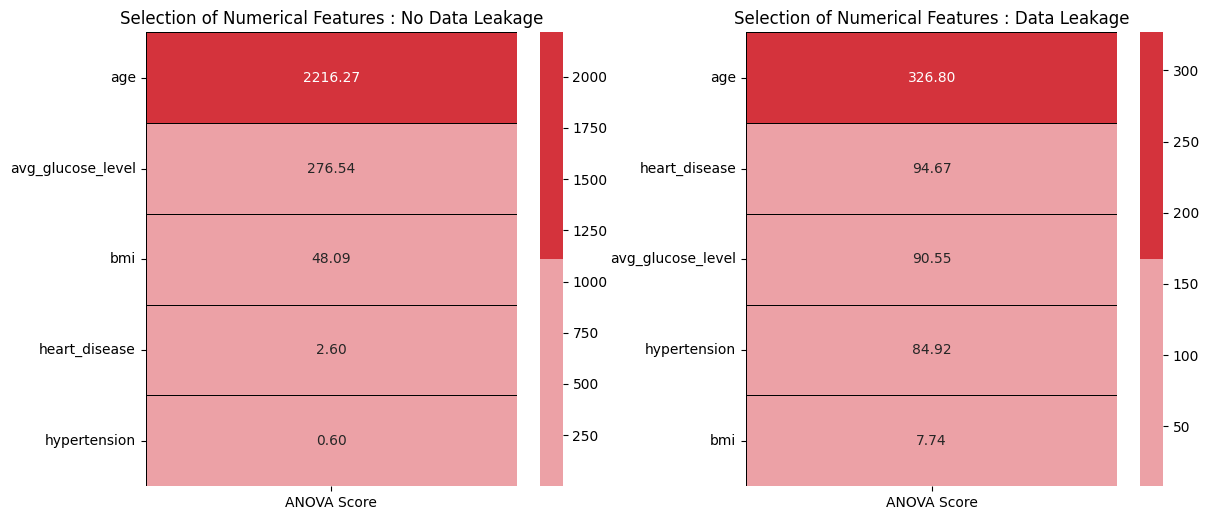

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

plt.subplot(1,2,1)
features = x_train.loc[:,numerical_cols]
target = y_train

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features : No Data Leakage');

plt.subplot(1,2,2)
features = df.loc[:,numerical_cols]
target = df.loc[:, 'stroke']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features : Data Leakage')

fig.tight_layout(pad = 0)
plt.show()

### Run the original ADS and obtain metrics

Cross Validation Score :  93.07%
ROC_AUC Score :  86.34%


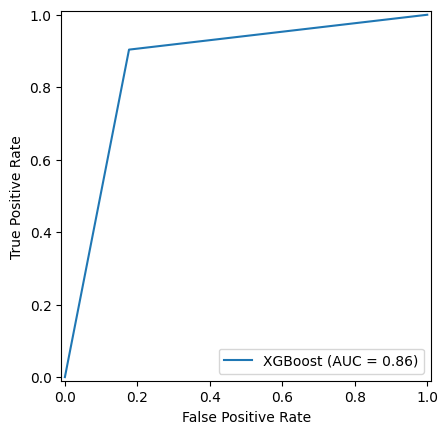

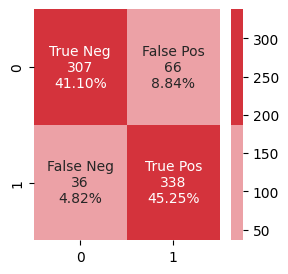

In [26]:
# run the ADS and view performance metrics
x_train, x_test = scaling(x_train, x_test)
classifier1 = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
performance1, fairness1, prediction1 = eval(classifier1, x_train,y_train, x_test, y_test)
df_res = store_res(performance1, 'Original ADS')

Let's look at the metrics for how the original ADS performed. We are primarily concerned with recall, FNR and fairness across the protected attribute of gender. Within context, the false negative rate represents the proportion of actual positives that are incorrectly identified as negative. It measures how often a test fails to detect a medical condition when it is actually present. 

We have to keep in mind however, that the original case study resampled BEFORE splitting the data into train-test. This meant there was data leakage as shown before. Further modifications to the data pipeline will adhere to best practices of resampling after train-test-split on the training sets only. Thus in future metrics, the FNR will largely be inconsequential due to the unbalanced distribution of the test sets. 

We will focus on the precision, recall and F1 scores of the models, with a lesser focus on actual false negative data points. 

In [27]:
df_res

,acc,ppv,npv,recall,f1,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR,FNRP,equalized_odds_ratio,demo_parity_diff,demo_parity_ratio,female_acc,female_sr,female_FNR,female_FPR,male_acc,male_sr,male_FNR,male_FPR
Original ADS,0.863,0.866,0.895,0.863,0.863,307,66,36,338,0.863,0.177,0.904,0.823,0.096,0.345,0.632,0.218,0.644,0.872,0.613,0.065,0.208,0.847,0.395,0.188,0.132


In [28]:
fairness1.by_group

,accuracy,selection_rate,FNR,FPR
gender,,,,
female,0.871743,0.613226,0.064748,0.208145
male,0.846774,0.395161,0.187500,0.131579


The metrics indicate that while accuracy across male and female attribute assignments are near equivalent, the false negative rate of males are extremely higher. The selection rate is the metric that contains the difference favorable prediction among subgroups, which further corroborates this. It is a course measure that is difficult to optimize but can be used to inform. 

## Looking at the metrics of the original ADS

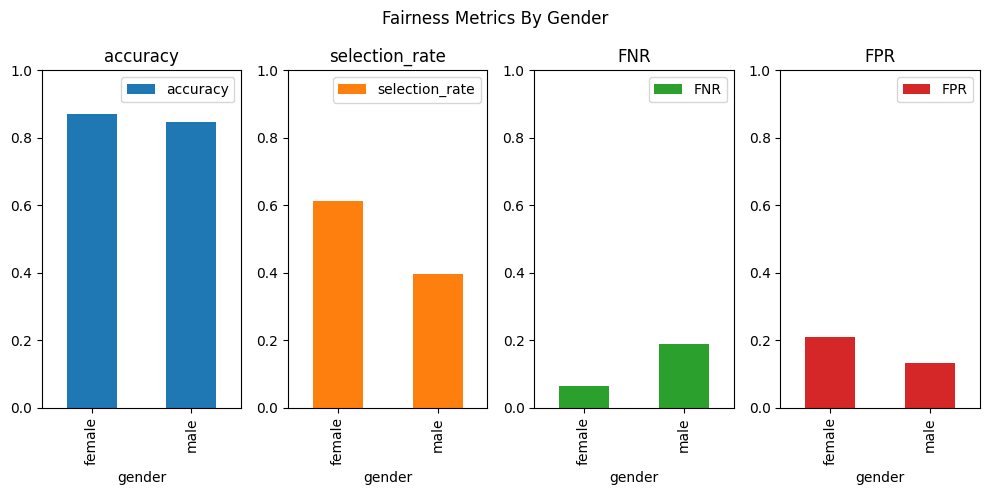

In [29]:
# visualize fairness metrics of original ADS by gender
# subplots, layout, legend, figsize, title
fairness1.by_group.plot.bar(subplots = True, layout = [1, 4] ,figsize = (10,5), ylim = [0,1], title = 'Fairness Metrics By Gender')
plt.tight_layout()

In [30]:
fairness1.ratio()

accuracy          0.971357
selection_rate    0.644397
FNR               0.345324
FPR               0.632151
dtype: float64

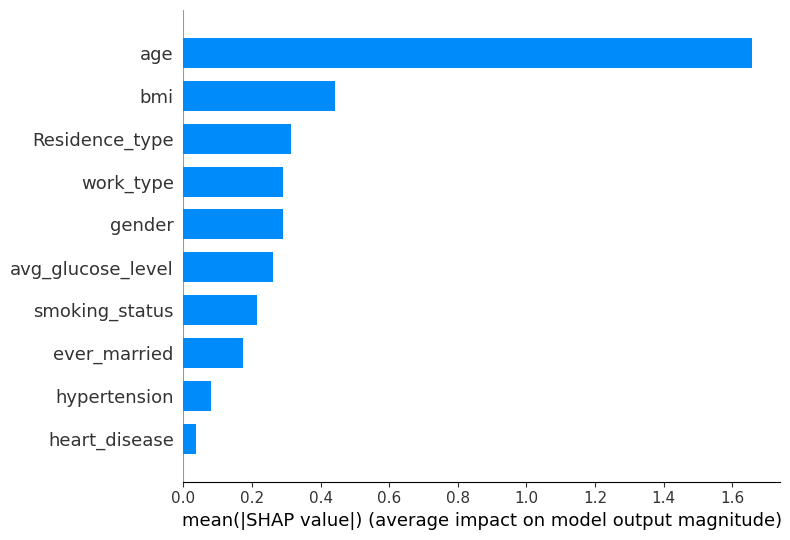

In [31]:
# feature importance from SHAP values
explainer = shap.TreeExplainer(classifier1)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar")

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

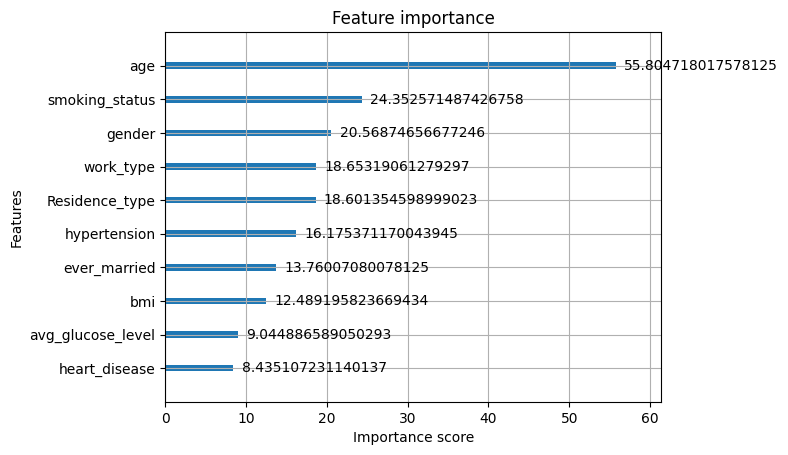

In [32]:
# feature importance from built in model using gain = number of times that feature was split in tree model
from xgboost import plot_importance
plot_importance(classifier1.get_booster(), importance_type = 'gain')

# Modification 1: Data Cleaning and / or Preprocessing
- SMOTE ratios or techniques (original, adasync, smotetomek, smoteenn)
- correlation remover

['Female' 'Male']
['No' 'Yes']
['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
['Rural' 'Urban']
['Unknown' 'formerly smoked' 'never smoked' 'smokes']
<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
419    1
420    1
421    1
422    1
423    1
Name: stroke, Length: 424, dtype: int64>
Counter({0: 212, 1: 212})
Counter({0: 174, 1: 174})
Counter({0: 116, 1: 115})
0 under_smote
['Female' 'Male']
['No' 'Yes']
['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
['Rural' 'Urban']
['Unknown' 'formerly smoked' 'never smoked' 'smokes']
<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
419    1
420    1
421    1
422    1
423    1
Name: stroke, Length: 424, dtype: int64>
Counter({0: 212, 1: 212})
Counter({0: 174, 1: 174})
Counter({0: 116, 1: 115})
1 adasyn
['Female' 'Male']
['No' 'Yes']
['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
['Rural' 'Urban']
['U

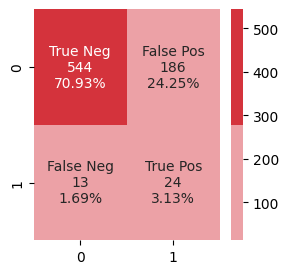

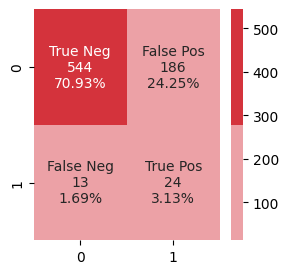

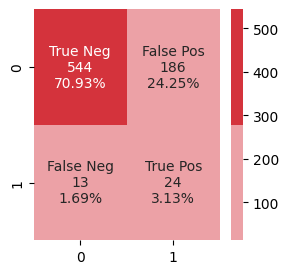

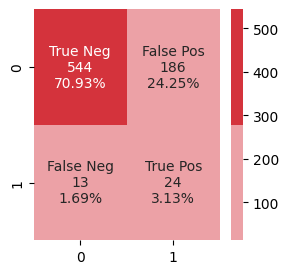

In [33]:
func = [under_smote, adasyn, smote_tomek, smote_enn]
for i in range(len(func)):
    x_train, x_test, y_train, y_test = preprocess_data(func = func)
    classifier2 = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
    performance2, fairness2, prediction2 = eval(classifier2, x_train, y_train, x_test, y_test, show_roc = False)
    name = ''
    if i == 0: 
        name = 'under_smote'
    elif i == 1:
        name = 'adasyn'
    elif i == 2:
        name = 'smote_tomek'
    else:
        name = 'smote_enn'
    print(i, name)
  
    df_res = store_res(performance2, name, overall_result=df_res)

In [35]:
df_res

,acc,ppv,npv,recall,f1,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR,FNRP,equalized_odds_ratio,demo_parity_diff,demo_parity_ratio,female_acc,female_sr,female_FNR,female_FPR,male_acc,male_sr,male_FNR,male_FPR
Original ADS,0.863,0.866,0.895,0.863,0.863,307,66,36,338,0.863,0.177,0.904,0.823,0.096,0.345,0.632,0.218,0.644,0.872,0.613,0.065,0.208,0.847,0.395,0.188,0.132
under_smote,0.741,0.935,0.977,0.741,0.814,544,186,13,24,0.697,0.255,0.649,0.745,0.351,0.583,0.762,0.037,0.873,0.749,0.258,0.429,0.242,0.729,0.295,0.250,0.272
adasyn,0.741,0.935,0.977,0.741,0.814,544,186,13,24,0.697,0.255,0.649,0.745,0.351,0.583,0.762,0.037,0.873,0.749,0.258,0.429,0.242,0.729,0.295,0.250,0.272
smote_tomek,0.741,0.935,0.977,0.741,0.814,544,186,13,24,0.697,0.255,0.649,0.745,0.351,0.583,0.762,0.037,0.873,0.749,0.258,0.429,0.242,0.729,0.295,0.250,0.272
smote_enn,0.741,0.935,0.977,0.741,0.814,544,186,13,24,0.697,0.255,0.649,0.745,0.351,0.583,0.762,0.037,0.873,0.749,0.258,0.429,0.242,0.729,0.295,0.250,0.272


We find that all over re-sampling methods reduce our metrics of choice (recall, precision, F1). This is expected since we implemented re-sampling after train-test-split. Therefore, although the metrics are lower, the tests were untouched and reflects real world distribution with a more realistic estimate. We see that different sampling methods had no effect on model performance at all. 

Now that the distribution is balanced correctly, we will look into tuning the model for overall performance. At the same time, we will test the best fairness intervention practices (pre-processing, post-processing)

### Modification 2: GridSearch for Hyper-Parameters


['Female' 'Male']
['No' 'Yes']
['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
['Rural' 'Urban']
['Unknown' 'formerly smoked' 'never smoked' 'smokes']
<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
419    1
420    1
421    1
422    1
423    1
Name: stroke, Length: 424, dtype: int64>
Fitting 5 folds for each of 96 candidates, totalling 480 fits


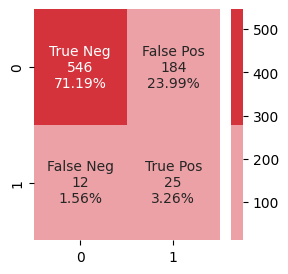

In [36]:
x_train, x_test, y_train, y_test = preprocess_data([under_smote])
classifier3 = XGBClassifier(booster = 'gbtree', objective = 'binary:logistic')
parameters = {'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': range(2, 10, 1), 
              'n_estimators': range(500, 2000, 500)}
grid_search = GridSearchCV(estimator = classifier3, param_grid = parameters, scoring = 'f1', n_jobs = 10, verbose = 3)
grid_search.fit(x_train, y_train)

classifier3 = grid_search.best_estimator_
performance4, fairness4, _ = eval(classifier3, x_train, y_train, x_test, y_test, show_roc = False)
df_res = store_res(performance4, 'GridSearch ADS', overall_result=df_res)


### Modification 3: Pre-processing Intervention with Correlation Remover for Fairness

['Female' 'Male']
['No' 'Yes']
['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
['Rural' 'Urban']
['Unknown' 'formerly smoked' 'never smoked' 'smokes']
<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
419    1
420    1
421    1
422    1
423    1
Name: stroke, Length: 424, dtype: int64>


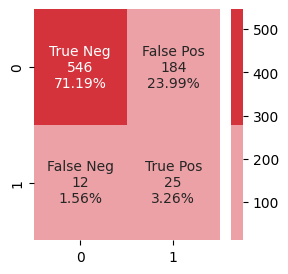

In [37]:
x_train, x_test, y_train, y_test = preprocess_data([under_smote])
x_train, x_test = corr_remover(x_train, x_test, sensitive_feature = 'gender')
classifier4 = grid_search.best_estimator_
performance3, fairness3, _ = eval(classifier4, x_train, y_train, x_test, y_test, show_roc = False)
df_res = store_res(performance3, 'Correlation Remover ADS', overall_result=df_res)

### Modification  4: Post-Processing Intervention with Threshold Optimzier (Equalized Odds)

['Female' 'Male']
['No' 'Yes']
['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
['Rural' 'Urban']
['Unknown' 'formerly smoked' 'never smoked' 'smokes']
<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
419    1
420    1
421    1
422    1
423    1
Name: stroke, Length: 424, dtype: int64>


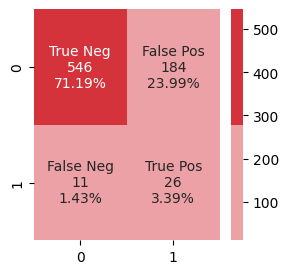

In [38]:
x_train, x_test, y_train, y_test = preprocess_data([under_smote])
classifier5 = ThresholdOptimizer(estimator=grid_search.best_estimator_, constraints = 'equalized_odds', prefit=True)
performance5, fairness5, _ = eval(classifier5, x_train, y_train, x_test, y_test, show_roc = False, sensitive_feature = 'gender')
df_res = store_res(performance5, 'Threshold Optimizer ADS', overall_result=df_res)

# Results and Summary:

In [39]:
# write out and save the results dataframe
df_res.to_csv('rds_res.csv', index = True)

In [40]:
pd.set_option('display.max_columns', None)
df_res = pd.read_csv('rds_res.csv')
cols = list(df_res.columns)
cols[0] = 'models'
df_res.columns = cols
df_res

,models,acc,ppv,npv,recall,f1,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR,FNRP,equalized_odds_ratio,demo_parity_diff,demo_parity_ratio,female_acc,female_sr,female_FNR,female_FPR,male_acc,male_sr,male_FNR,male_FPR
0,Original ADS,0.863,0.866,0.895,0.863,0.863,307,66,36,338,0.863,0.177,0.904,0.823,0.096,0.345,0.632,0.218,0.644,0.872,0.613,0.065,0.208,0.847,0.395,0.188,0.132
1,under_smote,0.741,0.935,0.977,0.741,0.814,544,186,13,24,0.697,0.255,0.649,0.745,0.351,0.583,0.762,0.037,0.873,0.749,0.258,0.429,0.242,0.729,0.295,0.250,0.272
2,adasyn,0.741,0.935,0.977,0.741,0.814,544,186,13,24,0.697,0.255,0.649,0.745,0.351,0.583,0.762,0.037,0.873,0.749,0.258,0.429,0.242,0.729,0.295,0.250,0.272
3,smote_tomek,0.741,0.935,0.977,0.741,0.814,544,186,13,24,0.697,0.255,0.649,0.745,0.351,0.583,0.762,0.037,0.873,0.749,0.258,0.429,0.242,0.729,0.295,0.250,0.272
4,smote_enn,0.741,0.935,0.977,0.741,0.814,544,186,13,24,0.697,0.255,0.649,0.745,0.351,0.583,0.762,0.037,0.873,0.749,0.258,0.429,0.242,0.729,0.295,0.250,0.272
5,GridSearch ADS,0.744,0.937,0.978,0.744,0.817,546,184,12,25,0.712,0.252,0.676,0.748,0.324,0.262,0.599,0.045,0.849,0.749,0.253,0.476,0.240,0.738,0.298,0.125,0.269
6,Correlation Remover ADS,0.744,0.937,0.978,0.744,0.817,546,184,12,25,0.712,0.252,0.676,0.748,0.324,0.262,0.599,0.045,0.849,0.749,0.253,0.476,0.240,0.738,0.298,0.125,0.269
7,Threshold Optimizer ADS,0.746,0.939,0.980,0.746,0.818,546,184,11,26,0.725,0.252,0.703,0.748,0.297,0.292,0.653,0.021,0.925,0.742,0.265,0.429,0.249,0.751,0.286,0.125,0.256


Remember that our metrics of choice for our context (stroke prediction) is recall, precision and F1 score. We built our ADS from correct sampling, into parameter tuning, into best fairness interventions. 

We see that after correctly sampling, precision went up, although our recall and f1 scores decreased. This is to be expected with our test sets now being true to the underlying population. Thus, the original ADS will not be considered when choosing best processes and model.

Our job was to then tune our XGBoost model to increase the base metrics, while testing two fairness interventions.

Correlation remover is pre-processing tool to reduce the correlation between non-sensitive features and the sensitive attributes within a dataset. The purpose of this tool is to remove or mitigate bias before the training. 

ThresholdOptimizer is a post-processing algorithm designed to improve fairness in binary classifcation tasks. It applys group specific thresholds to the predictions of a classifier, optimizing performance while following a fairness constraint. 

The final results of corrected sampling, tuning and fairness metrics shows that GridSearch with a Threshold Optimizer is our choice for predicting stroke. It achieved the highest precision of 0.939, a recall of 0.746, and tied for the highest F1 score of 0.818.

It also had the least amount of false negatives at 11 cases, and a false negative rate of 0.297.

In terms of fairness it had the lowest FNR across the protected attribute, the lowest demographic parity and the highest demographic parity ratio. 

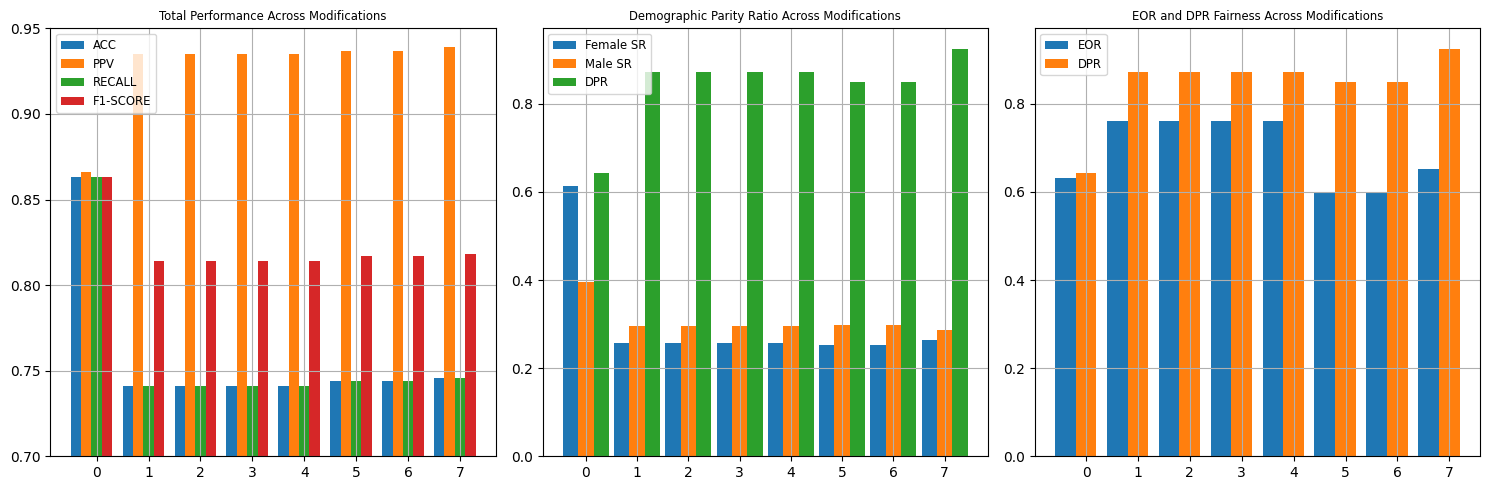

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
#X = df_res['models'].unique()
X_ticks = np.arange(8)


ax[0].bar(X_ticks - .4, df_res.acc, 0.2, label = 'ACC')
ax[0].bar(X_ticks - .2, df_res.ppv, 0.2, label = 'PPV')
ax[0].bar(X_ticks - .0, df_res.recall, 0.2, label = 'RECALL')
ax[0].bar(X_ticks + .2, df_res.f1, 0.2, label = 'F1-SCORE')
ax[0].set_ylim((.7, .95))
ax[0].legend(fontsize ='small')
ax[0].set_title('Total Performance Across Modifications',fontsize='small')
ax[0].grid()

ax[1].bar(X_ticks - .3, df_res.female_sr, 0.3, label = 'Female SR')
ax[1].bar(X_ticks - 0, df_res.male_sr, 0.3, label = 'Male SR')
ax[1].bar(X_ticks + .3, df_res.demo_parity_ratio, 0.3, label = 'DPR')
ax[1].legend(fontsize ='small')
ax[1].set_title('Demographic Parity Ratio Across Modifications', fontsize='small')
ax[1].grid()

ax[2].bar(X_ticks - .4, df_res.equalized_odds_ratio, 0.4, label = 'EOR')
ax[2].bar(X_ticks - 0, df_res.demo_parity_ratio, 0.4, label = 'DPR')
ax[2].legend(fontsize ='small')
ax[2].set_title('EOR and DPR Fairness Across Modifications', fontsize='small')
ax[2].grid()

plt.tight_layout()

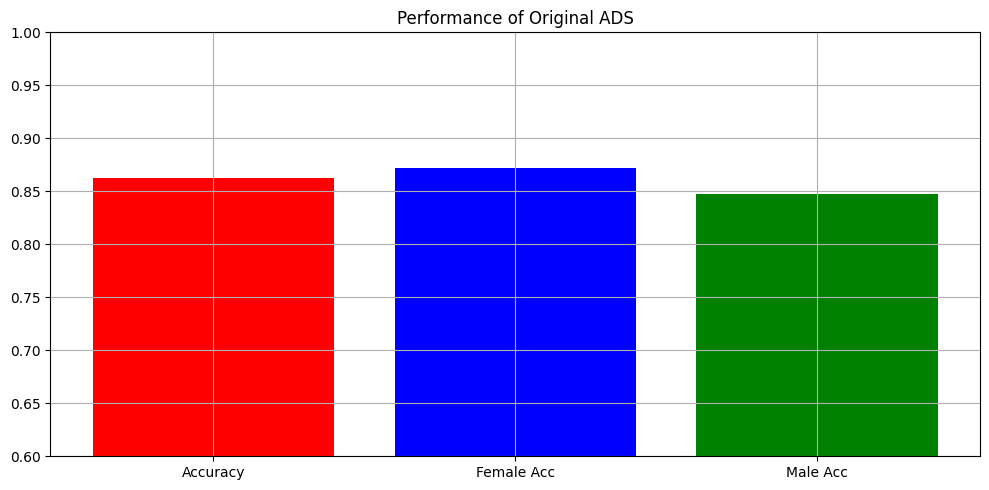

In [42]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 5))
X = ['Accuracy', 'Female Acc', 'Male Acc']
Y = [df_res.acc[0], df_res.female_acc[0], df_res.male_acc[0]]
X_ticks = np.arange(len(X))

ax.bar(X, Y, color = ['red','blue','green'])
ax.set_title('Performance of Original ADS',fontsize='large')
ax.set_ylim((0.6, 1))
ax.grid()

plt.tight_layout()